**Tensorflow GPU**

In [8]:
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 43kB/s 


**GPU Type**

In [9]:
!nvidia-smi

Mon Mar  8 11:54:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |    478MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Tensorflow Import**

In [10]:
import tensorflow as tf


**Libraries (InceptionV3)**

In [11]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

**Image Size and Paths**

In [12]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/indoor/train'
valid_path = '/content/drive/MyDrive/indoor/test'

**Inception V3 with imagenet weights**


In [13]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 0s 0us/step


In [14]:
for layer in inception.layers:
    layer.trainable = False

**Number of Classes**

In [15]:
folders = glob('/content/drive/MyDrive/indoor/train/*')
folders

['/content/drive/MyDrive/indoor/train/Diningroom',
 '/content/drive/MyDrive/indoor/train/Livingroom',
 '/content/drive/MyDrive/indoor/train/Bedroom']

In [16]:
x = Flatten()(inception.output)

***Activation softmax due to multiple categories*** 

In [17]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

**Summary**

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

**Adam Optimizer**

In [21]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

**Data Augmentation**

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [23]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/indoor/train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 930 images belonging to 3 classes.


In [24]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/indoor/test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 179 images belonging to 3 classes.


**Training**

In [25]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
59/59 [==============================] - 465s 7s/step - loss: 7.8744 - accuracy: 0.5697 - val_loss: 5.7119 - val_accuracy: 0.6536
Epoch 2/30
59/59 [==============================] - 21s 350ms/step - loss: 2.5714 - accuracy: 0.7790 - val_loss: 2.9739 - val_accuracy: 0.6480
Epoch 3/30
59/59 [==============================] - 20s 348ms/step - loss: 1.4542 - accuracy: 0.8176 - val_loss: 5.5056 - val_accuracy: 0.5978
Epoch 4/30
59/59 [==============================] - 20s 346ms/step - loss: 2.0888 - accuracy: 0.8238 - val_loss: 4.0605 - val_accuracy: 0.7263
Epoch 5/30
59/59 [==============================] - 20s 345ms/step - loss: 1.2558 - accuracy: 0.8618 - val_loss: 4.8437 - val_accuracy: 0.5866
Epoch 6/30
59/59 [==============================] - 20s 347ms/step - loss: 0.8714 - accuracy: 0.8918 - val_loss: 4.1372 - val_accuracy: 0.6313
Epoch 7/30
59/59 [==============================] - 20s 345ms/step - loss: 0.8330 - accuracy: 0.9032 - val_loss: 3.2708 - val_accuracy: 0.7654
E

**Saving the Model**

In [26]:
from tensorflow.keras.models import load_model

model.save('room_30.h5')

**Converting to TfLite**

In [2]:
import tensorflow as tf
tflite_model = tf.keras.models.load_model('/content/drive/MyDrive/room.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("rooms.tflite", "wb").write(tflite_save)

INFO:tensorflow:Assets written to: /tmp/tmpt4q28kw0/assets


87736896

**Testing**

In [30]:
y_pred = model.predict(test_set)
y_pred

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 2.56235661e-19],
       [7.21391625e-05, 9.99927878e-01, 3.11638620e-21],
       [1.00000000e+00, 2.77296119e-09, 1.26482616e-17],
       [1.00000000e+00, 2.77296119e-09, 1.26482616e-17],
       [2.13488927e-12, 1.00000000e+00, 5.08085598e-13],
       [1.00000000e+00, 2.50732175e-17, 3.98027835e-22],
       [1.68588906e-15, 1.00000000e+00, 1.16609289e-17],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.55263886e-04, 1.54941438e-06, 9.99843121e-01],
       [1.00000000e+00, 3.47820506e-09, 5.11006584e-11],
       [1.34446145e-06, 9.99997973e-01, 7.41084989e-07],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.50732175e-17, 3.98027835e-22],
       [9.99505997e-01, 8.18522835e-15, 4.93975647e-04],
       [1.00000000e+00, 4.12390

**Loss Accuracy Curves**

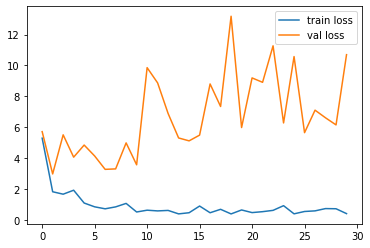

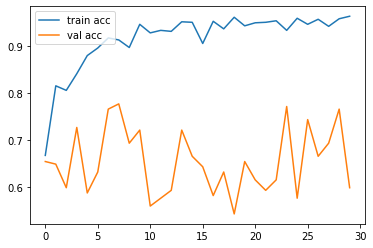

<Figure size 432x288 with 0 Axes>

In [28]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

**Confusion Matrix**

In [31]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [33]:
y_pred = np.argmax(y_pred, axis=1)

In [34]:
y_pred

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 0,
       2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2,
       1, 2, 1, 2, 1, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 2, 0, 0, 1, 0,
       1, 1, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 1, 0, 1, 0, 1, 2, 0, 2, 0, 2,
       1, 2, 2, 0, 0, 1, 1, 2, 2, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       2, 2, 0])